In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Bahdanau Attention
$$c_{t'} = \sum_{t=1}^{T_x} a(\mathbf{q}_{t' - 1}, \mathbf{h}_{t'}) \mathbf{h}_t, \text{where}\ \mathbf{c}\ \text{is the context,}\ \mathbf{q}\ \text{is the query,}\ \mathbf{h}\ \text{is the hidden state}$$
- Notice $h$ serves as *both* the key and value
- $a$ is the scoring function. The book used the Additive one

In [5]:
from naml.modules import torch
from naml.modules.sequence import Seq2SeqAttentionDecoder, Seq2SeqEncoder

encoder = Seq2SeqEncoder(10, 8, 16, 2, 0.0)
# Implementation details here vvv
decoder = Seq2SeqAttentionDecoder(10, 8, 16, 2, 0.0)
encoder.eval(), decoder.eval()

X = torch.zeros((4, 7)).long() # [batch_size, num_steps]
Y_enc, H_enc = encoder(X)
Y_dec, H_dec = decoder.forward(X, H_enc, Y_enc)
Y_dec.shape, Y_enc.shape, H_dec.shape, H_enc.shape

(torch.Size([4, 7, 10]),
 torch.Size([7, 4, 16]),
 torch.Size([2, 4, 16]),
 torch.Size([2, 4, 16]))

## Training & Prediction
Stucture-wise, this is similar to the `seq2seq` one. Most of the code here are copied from the previous notebook.

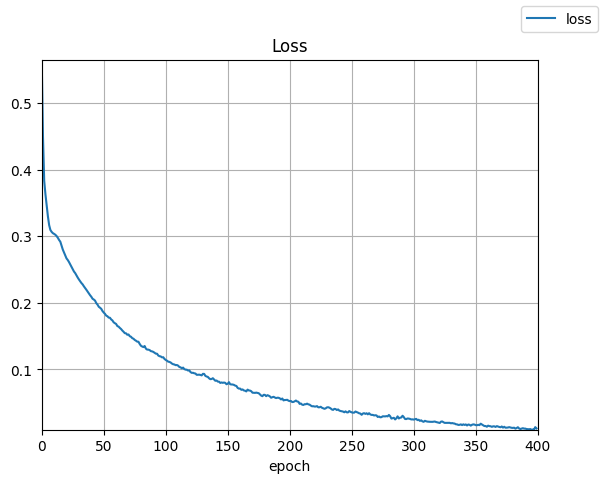

Loss:   0%|          | 0/400 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

In [ ]:
from naml.modules.sequence import train_seq2seq, EncoderDecoder, AdditiveAttention, DotProductAttention
from naml.text import Vocabulary

embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs = 0.005, 400

from naml.text import flatten
from naml.dataset import Datasets
from naml.dataset.nmt import load_nmt
datasets = Datasets("~/naml-data")
src_words, target_words = load_nmt(datasets, 'cmn', 'eng', max_examples=500)

src_vocab, tgt_vocab = Vocabulary(flatten(src_words)), Vocabulary(flatten(target_words))
encoder = Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqAttentionDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout, AdditiveAttention)
# DotProductAttention   26s, loss=0.0031
# AdditiveAttention     28s, loss=0.0114
net = EncoderDecoder(encoder, decoder)
train_seq2seq(net, lr, num_epochs, src_vocab, tgt_vocab, src_words, target_words, batch_size, num_steps)


In [7]:
from naml.dataset.nmt import nmt_tokenizer
from naml.modules.sequence import predict_seq2seq
from naml.sequence import bleu
def from_src_string(src : str):
    src_indices = nmt_tokenizer(src.lower())
    src_indices = src_vocab.to_indices(src_indices)    
    src_indices = src_vocab.truncate_pad(src_indices, num_steps).long()    
    return src_indices        
for i in range(20,25):
    src = ' '.join(src_words[i])
    tgt = ' '.join(target_words[i])
    pred = list(predict_seq2seq(net, from_src_string(src), tgt_vocab, num_steps))
    score = bleu(target_words[i], pred)
    print(f'{src} => {" ".join(pred)} <= {tgt}, {score}')
''.join(list(predict_seq2seq(net, from_src_string("this is me"), tgt_vocab, num_steps)))

thanks ! => 谢谢！ <= 谢谢！, 1.0
try it . => 试试吧。 <= 试试吧。, 1.0
we try . => 我们来试试。 <= 我们来试试。, 1.0
why me ? => 为什么是我？ <= 为什么是我？, 1.0
ask tom . => 去打汤姆。 <= 去问汤姆。, 0.0


'去洗洗吧。'